In [1]:
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

In C:\Users\hyoun\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\hyoun\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\hyoun\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\hyoun\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\hyoun\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
# Data는 Tab으로 구분되어 있음 
train = pd.read_csv("ml-100k/ua.base", sep="\t", names=['user', 'movie', 'rating', 'timestamp'])
test = pd.read_csv("ml-100k/ua.test", sep="\t", names=['user', 'movie', 'rating', 'timestamp'])

In [3]:
train.head()

,user,movie,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [4]:
# 데이터 형태 변환 
items = torch.LongTensor(train['movie'])
users = torch.LongTensor(train['user'])
ratings = torch.FloatTensor(train['rating'])
items_test = torch.LongTensor(test['movie'])
users_test = torch.LongTensor(test['user'])
ratings_test = torch.FloatTensor(test['rating'])

In [5]:
rank = 10
numItems = items.max() + 1 # M개의 Users
numUsers = users.max() + 1 # N개의 Items
# 임의의 (M,10) , (n,10)의 행렬 생성 
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

In [6]:
# optimizer = torch.optim.Adam([P, Q], lr= 0.1)
# for epoch in range(1000):
#     hypothesis = torch.sum(P[items] * Q[users], dim= 1)
#     cost = F.mse_loss(hypothesis ,ratings)
#     optimizer.zero_grad()
#     cost.backward()
#     optimizer.step()
#     if epoch % 100 == 0:
#         print("epoch: {}, cost: {:.6f}" .format(epoch, cost.item()))

In [7]:
Q[users].shape

torch.Size([90570, 10])

In [8]:
X = []
Y = []

optimizer = torch.optim.Adam([P, Q], lr= 0.1)
for epoch in range(1000):
    # P[items]의 의미는 item의 개수만큼 만들어진 데이터를 가지고 있는 데이터에 맞추어 증식
    hypothesis = torch.sum(P[items] * Q[users], dim= 1)
    cost = F.mse_loss(hypothesis ,ratings)
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    X.append(epoch)
    Y.append(cost)
    if epoch % 100 == 0:
        print("epoch: {}, cost: {:.6f}" .format(epoch, cost.item()))

epoch: 0, cost: 23.351402
epoch: 100, cost: 0.568511
epoch: 200, cost: 0.497906
epoch: 300, cost: 0.473223
epoch: 400, cost: 0.461902
epoch: 500, cost: 0.455760
epoch: 600, cost: 0.451938
epoch: 700, cost: 0.449223
epoch: 800, cost: 0.447265
epoch: 900, cost: 0.445871


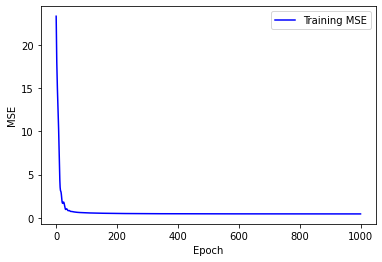

In [9]:
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.legend()
plt.show()

## Test결과 삽입

In [10]:
rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

In [11]:
X = []
Y = []
Y_test = []

optimizer = torch.optim.Adam([P, Q], lr= 0.1)
for epoch in range(1000):
    hypothesis = torch.sum(P[items] * Q[users], dim= 1)
    cost = F.mse_loss(hypothesis ,ratings)
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    X.append(epoch)
    Y.append(cost)
    with torch.no_grad():
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)
        cost_test = F.mse_loss(hypo_test, ratings_test)
        Y_test.append(cost_test)
    if epoch % 100 == 0:
        print("epoch: {}, cost: {:.6f}" .format(epoch, cost.item()))

epoch: 0, cost: 23.797020
epoch: 100, cost: 0.562039
epoch: 200, cost: 0.494565
epoch: 300, cost: 0.472840
epoch: 400, cost: 0.462528
epoch: 500, cost: 0.456559
epoch: 600, cost: 0.452671
epoch: 700, cost: 0.449970
epoch: 800, cost: 0.447914
epoch: 900, cost: 0.446298


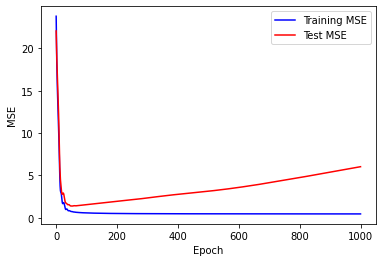

In [12]:
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

# Regularization 추가

In [13]:
rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

In [14]:
lambda1 = 0.0001
lambda2 = 0.0001
X = []
Y = []
Y_test = []

optimizer = torch.optim.Adam([P, Q], lr= 0.1)
for epoch in range(1000):
    hypothesis = torch.sum(P[items] * Q[users], dim= 1)
    cost = F.mse_loss(hypothesis ,ratings)
    loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    X.append(epoch)
    Y.append(cost)
    with torch.no_grad():
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)
        cost_test = F.mse_loss(hypo_test, ratings_test)
        Y_test.append(cost_test)
    if epoch % 100 == 0:
        print("epoch: {}, cost: {:.6f}" .format(epoch, cost.item()))

epoch: 0, cost: 23.830935
epoch: 100, cost: 0.690889
epoch: 200, cost: 0.641221
epoch: 300, cost: 0.631486
epoch: 400, cost: 0.629105
epoch: 500, cost: 0.628084
epoch: 600, cost: 0.627471
epoch: 700, cost: 0.627061
epoch: 800, cost: 0.626777
epoch: 900, cost: 0.626579


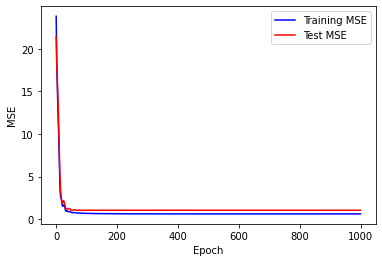

In [15]:
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

# Bias 추가

In [16]:
rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

In [17]:
lambda3 = 0.001
lambda4 = 0.001
bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()

In [18]:
lambda1 = 0.0001
lambda2 = 0.0001
X = []
Y = []
Y_test = []

optimizer = torch.optim.Adam([P, Q], lr= 0.1)
for epoch in range(1000):
    hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]
    cost = F.mse_loss(hypothesis ,ratings)
    loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) + lambda3 * torch.sum(bias_item ** 2) + lambda4 * torch.sum(bias_user ** 2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    X.append(epoch)
    Y.append(cost)
    with torch.no_grad():
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)
        cost_test = F.mse_loss(hypo_test, ratings_test)
        Y_test.append(cost_test)
    if epoch % 100 == 0:
        print("epoch: {}, cost: {:.6f}" .format(epoch, cost.item()))

epoch: 0, cost: 13.107369
epoch: 100, cost: 0.674281
epoch: 200, cost: 0.647033
epoch: 300, cost: 0.641588
epoch: 400, cost: 0.639835
epoch: 500, cost: 0.639496
epoch: 600, cost: 0.639344
epoch: 700, cost: 0.639214
epoch: 800, cost: 0.639091
epoch: 900, cost: 0.639013


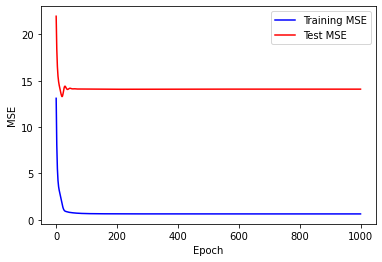

In [19]:
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

----------

# Running rate 수정

In [23]:
rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

In [24]:
lambda3 = 0.001
lambda4 = 0.001
bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()

In [25]:
lambda1 = 0.0001
lambda2 = 0.0001
X = []
Y = []
Y_test = []

optimizer = torch.optim.Adam([P, Q], lr= 0.05)
for epoch in range(1000):
    hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]
    cost = F.mse_loss(hypothesis ,ratings)
    loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) + lambda3 * torch.sum(bias_item ** 2) + lambda4 * torch.sum(bias_user ** 2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    X.append(epoch)
    Y.append(cost)
    with torch.no_grad():
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)
        cost_test = F.mse_loss(hypo_test, ratings_test)
        Y_test.append(cost_test)
    if epoch % 100 == 0:
        print("epoch: {}, cost: {:.6f}" .format(epoch, cost.item()))

epoch: 0, cost: 12.941305
epoch: 100, cost: 0.742660
epoch: 200, cost: 0.668740
epoch: 300, cost: 0.649038
epoch: 400, cost: 0.642609
epoch: 500, cost: 0.639728
epoch: 600, cost: 0.638409
epoch: 700, cost: 0.637777
epoch: 800, cost: 0.637447
epoch: 900, cost: 0.637233


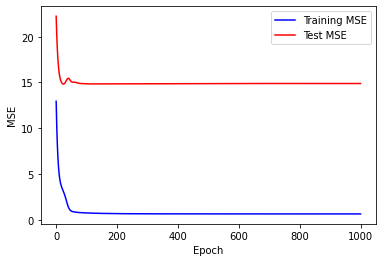

In [26]:
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

# optimizer 변형 + running rate 수정 

In [27]:
rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

In [28]:
lambda3 = 0.001
lambda4 = 0.001
bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()

In [29]:
lambda1 = 0.0001
lambda2 = 0.0001
X = []
Y = []
Y_test = []

optimizer = torch.optim.RMSprop([P, Q], lr= 0.05)
for epoch in range(1000):
    hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]
    cost = F.mse_loss(hypothesis ,ratings)
    loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) + lambda3 * torch.sum(bias_item ** 2) + lambda4 * torch.sum(bias_user ** 2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    X.append(epoch)
    Y.append(cost)
    with torch.no_grad():
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)
        cost_test = F.mse_loss(hypo_test, ratings_test)
        Y_test.append(cost_test)
    if epoch % 100 == 0:
        print("epoch: {}, cost: {:.6f}" .format(epoch, cost.item()))

epoch: 0, cost: 13.535536
epoch: 100, cost: 0.697087
epoch: 200, cost: 0.642984
epoch: 300, cost: 0.655112
epoch: 400, cost: 0.667997
epoch: 500, cost: 0.630241
epoch: 600, cost: 0.659937
epoch: 700, cost: 0.675225
epoch: 800, cost: 0.649525
epoch: 900, cost: 0.635261


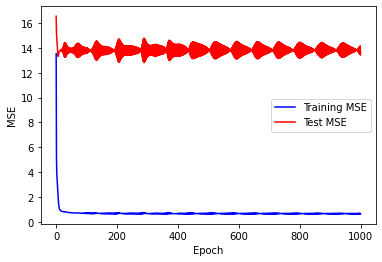

In [30]:
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

# optimizer 변형 + running rate 수정 + rank 변형 

In [31]:
rank = 15
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

In [32]:
lambda3 = 0.001
lambda4 = 0.001
bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()

In [34]:
lambda1 = 0.0001
lambda2 = 0.0001
X = []
Y = []
Y_test = []

optimizer = torch.optim.RMSprop([P, Q], lr= 0.05)
for epoch in range(1000):
    hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]
    cost = F.mse_loss(hypothesis ,ratings)
    loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) + lambda3 * torch.sum(bias_item ** 2) + lambda4 * torch.sum(bias_user ** 2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    X.append(epoch)
    Y.append(cost)
    with torch.no_grad():
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)
        cost_test = F.mse_loss(hypo_test, ratings_test)
        Y_test.append(cost_test)
    if epoch % 100 == 0:
        print("epoch: {}, cost: {:.6f}" .format(epoch, cost.item()))

epoch: 0, cost: 17.354443
epoch: 100, cost: 0.612096
epoch: 200, cost: 0.581318
epoch: 300, cost: 0.594169
epoch: 400, cost: 0.613801
epoch: 500, cost: 0.579843
epoch: 600, cost: 0.562491
epoch: 700, cost: 0.613067
epoch: 800, cost: 0.609380
epoch: 900, cost: 0.579607


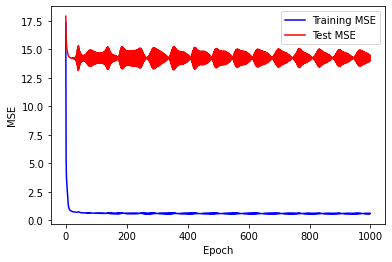

In [35]:
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

# 규제 추가 + learning Rate 수정

In [10]:
rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

In [11]:
lambda1 = 0.0001
lambda2 = 0.0001
X = []
Y = []
Y_test = []

optimizer = torch.optim.Adam([P, Q], lr= 0.05)
for epoch in range(1000):
    hypothesis = torch.sum(P[items] * Q[users], dim= 1)
    cost = F.mse_loss(hypothesis ,ratings)
    loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    X.append(epoch)
    Y.append(cost)
    with torch.no_grad():
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)
        cost_test = F.mse_loss(hypo_test, ratings_test)
        Y_test.append(cost_test)
    if epoch % 100 == 0:
        print("epoch: {}, cost: {:.6f}" .format(epoch, cost.item()))

epoch: 0, cost: 23.623707
epoch: 100, cost: 0.758302
epoch: 200, cost: 0.680023
epoch: 300, cost: 0.647342
epoch: 400, cost: 0.635925
epoch: 500, cost: 0.631392
epoch: 600, cost: 0.629552
epoch: 700, cost: 0.628655
epoch: 800, cost: 0.628080
epoch: 900, cost: 0.627649


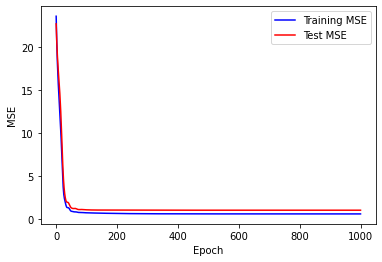

In [12]:
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

In [21]:
print("Test MSE : ", Y_test[-1])

Test MSE :  tensor(1.0583)


# 규제 추가 + optimzer 수정

In [22]:
rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

In [24]:
lambda1 = 0.0001
lambda2 = 0.0001
X = []
Y = []
Y_test = []

optimizer = torch.optim.RMSprop([P, Q], lr= 0.05)
for epoch in range(1000):
    hypothesis = torch.sum(P[items] * Q[users], dim= 1)
    cost = F.mse_loss(hypothesis ,ratings)
    loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    X.append(epoch)
    Y.append(cost)
    with torch.no_grad():
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)
        cost_test = F.mse_loss(hypo_test, ratings_test)
        Y_test.append(cost_test)
    if epoch % 100 == 0:
        print("epoch: {}, cost: {:.6f}" .format(epoch, cost.item()))

epoch: 0, cost: 24.388842
epoch: 100, cost: 0.689016
epoch: 200, cost: 0.651809
epoch: 300, cost: 0.637167
epoch: 400, cost: 0.630447
epoch: 500, cost: 0.627018
epoch: 600, cost: 0.626577
epoch: 700, cost: 0.625366
epoch: 800, cost: 0.624518
epoch: 900, cost: 0.623659


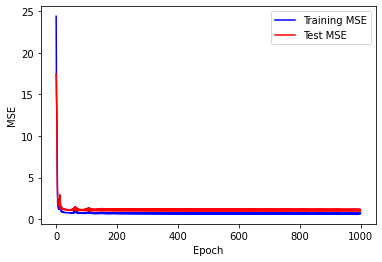

In [25]:
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

In [26]:
print("Test MSE : ", Y_test[-1])

Test MSE :  tensor(0.9964)


# 규제 추가 + optimzer 수정 + learning Rate 수정

In [28]:
rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

In [29]:
lambda1 = 0.0001
lambda2 = 0.0001
X = []
Y = []
Y_test = []

optimizer = torch.optim.RMSprop([P, Q], lr= 0.01)
for epoch in range(1000):
    hypothesis = torch.sum(P[items] * Q[users], dim= 1)
    cost = F.mse_loss(hypothesis ,ratings)
    loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    X.append(epoch)
    Y.append(cost)
    with torch.no_grad():
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)
        cost_test = F.mse_loss(hypo_test, ratings_test)
        Y_test.append(cost_test)
    if epoch % 100 == 0:
        print("epoch: {}, cost: {:.6f}" .format(epoch, cost.item()))

epoch: 0, cost: 23.467537
epoch: 100, cost: 1.049002
epoch: 200, cost: 0.828648
epoch: 300, cost: 0.747696
epoch: 400, cost: 0.689175
epoch: 500, cost: 0.651563
epoch: 600, cost: 0.632921
epoch: 700, cost: 0.625347
epoch: 800, cost: 0.622259
epoch: 900, cost: 0.620787


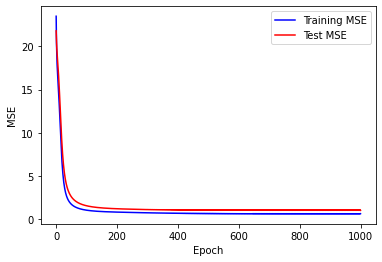

In [30]:
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

In [31]:
print("Test MSE : ", Y_test[-1])

Test MSE :  tensor(1.0321)


# 규제 추가 + optimzer 수정 + learning Rate 수정

In [32]:
rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

In [33]:
lambda1 = 0.0001
lambda2 = 0.0001
X = []
Y = []
Y_test = []

optimizer = torch.optim.RMSprop([P, Q], lr= 0.1)
for epoch in range(1000):
    hypothesis = torch.sum(P[items] * Q[users], dim= 1)
    cost = F.mse_loss(hypothesis ,ratings)
    loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    X.append(epoch)
    Y.append(cost)
    with torch.no_grad():
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)
        cost_test = F.mse_loss(hypo_test, ratings_test)
        Y_test.append(cost_test)
    if epoch % 100 == 0:
        print("epoch: {}, cost: {:.6f}" .format(epoch, cost.item()))

epoch: 0, cost: 24.030554
epoch: 100, cost: 0.704758
epoch: 200, cost: 0.665310
epoch: 300, cost: 0.643362
epoch: 400, cost: 0.630233
epoch: 500, cost: 0.627513
epoch: 600, cost: 0.631391
epoch: 700, cost: 0.634791
epoch: 800, cost: 0.635658
epoch: 900, cost: 0.638416


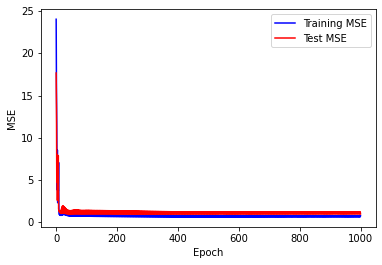

In [34]:
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

In [35]:
print("Test MSE : ", Y_test[-1])

Test MSE :  tensor(0.9943)


In [4]:
import numpy as np
import pandas as pd

In [3]:
p = [[-0.07336096998981455, -1.1868492419069463, -0.6832567886872725, 0.3374903259629553, 0.5061446103182706, -0.7094788795167749, 0.033505354838615116, 0.7542187442833727, -0.5679126937281002, -0.2221675697206096], [0.36167409936167005, -0.8357015389026892, -0.9908472737114803, 0.6002525352580729, 0.4599075583083665, -0.9662327149919435, -0.1848314856164792, 0.34917748129273785, -0.43767237886712274, -0.29261063618868516], [0.11730757345341974, -0.5306767688857185, -0.5662840461289441, 0.562890754253776, 0.6559638888747604, -1.0067127567750436, 0.06374742549464658, 0.4762064100553592, -0.29412342118168316, -0.34207529622923444], [0.024482111581551665, -0.4869831439028395, -0.5838825479942433, 0.49122316207974515, 0.7100908876733577, -0.7224034283389437, 0.3735144574274408, 0.41640354235200805, -0.40932787915176533, -0.23993775487550476], [0.13332297468222068, -0.9289419436063923, -0.9010732325374103, 0.45792402021709033, 0.6192196971568905, -1.1555834383261008, -0.05364254468166437, 0.12426027680411324, -0.13749563618807398, -0.24641231273407818], [-0.08817953120251332, -0.7480716044083238, -1.0371376774273813, 0.5249423022614792, 0.6726528027793393, -0.7480016250628978, -0.00936461944002076, 0.691860584076494, -0.2316447970442823, -0.33110106456661015], [0.5952142155729234, -1.0821536034345627, -0.9888386838138103, 0.31253096321597695, 0.48847488909814274, -0.7098551485687494, -0.10869534872472286, 0.5944515438750386, -0.5550296464934945, -0.7724123150110245], [-0.24781300638916723, -0.5548243161879087, -0.5664832393287501, 0.64927614983498, 0.6040199035615251, -0.8874111618650588, 0.47018635488654437, 0.43372953349822446, -0.07261321319751196, -0.17507943271745094], [-0.25144619177471056, -1.108523049333074, -1.1620049943795074, 0.6734304924973765, 0.4166405755221038, -0.9013176783248111, 0.07417192755619416, 0.31316552393616653, 0.16815026620505713, -0.25030816457578325], [0.1946741420775652, -1.366152858734131, -0.6764010787010193, 0.6147973954677581, 0.6522301658987999, -0.6733310282230377, 0.2014568779617548, 0.6166784435510635, 0.5539151489734649, -0.24110571891069413], np.NaN, [0.6839983036572282, -0.7303962748159062, -1.297385036945343, 0.5789091953669082, 0.3128092232244936, -0.964651267636906, -0.07108271409842101, 0.2782644336535172, -0.1503794056532735, 0.25425333593210037], [-0.15769492948117356, -0.8328967028194003, -0.9952411694659127, 0.40118331060641343, 0.5826943058106634, -0.6296512727936109, 0.4713478037880527, 0.6553088322281837, -0.26525634200208714, -0.2731745912383], [0.13555201976277836, -0.7790203622796319, -0.8585371402176943, 0.7513239726875768, 0.5662266506503025, -0.8183356496420774, -0.18087057724143518, 0.568741606153322, 0.22667687778558696, -0.34094875328468555], [0.28006212040781975, -0.7745314035564661, -0.5885491762310266, 1.221709430217743, 0.27770418073487235, -0.987280011177063, -0.1110464070661692, -0.056764028035104275, -0.1563648640876636, -0.15791325829923153], [-0.5042905999081475, -1.0576011143168624, -0.8788331327389698, 0.4335530572095696, 0.4931127704223808, -0.9764742790436258, 0.09419648664794406, 0.819552152056475, -0.03258214717284225, -0.08221814634126363]]

In [10]:
for i in p:
    sum([pd.isna(i)])

In [11]:
sum([pd.isna(i)])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])